Load backtest object

In [60]:
import pickle

class backtest_object:
  def __init__(self,grid_search, X, y, best_estim_preds, final_model):
    self.grid_search = grid_search
    self.X = X
    self.y = y
    self.best_estim_preds = best_estim_preds
    self.final_model = best_gbm

def Acc_Score(y_true,y_pred):
    global ys
    ys.append(y_pred)
    acc = accuracy_score(y_true, y_pred)    
    return acc

# Load the object from the file
with open('backtest_object_10Y_UST_v1.pkl', 'rb') as file:
    backtest_object_10Y_UST_v1 = pickle.load(file)

In [61]:
# Print the best hyperparameters
print("Best Hyperparameters:", backtest_object_10Y_UST_v1.grid_search.best_params_)
print(f'Accuracy of the Best Hyperparameters: {backtest_object_10Y_UST_v1.grid_search.best_score_:.4f}')


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 50, 'subsample': 1}
Accuracy of the Best Hyperparameters: 0.6235


In [62]:
X = backtest_object_10Y_UST_v1.X
y = backtest_object_10Y_UST_v1.y
y_preds = backtest_object_10Y_UST_v1.best_estim_preds

In [63]:
y.tail()

Date
2023-09-03    SHORT
2023-09-10    SHORT
2023-09-17    SHORT
2023-09-24    SHORT
2023-10-01    SHORT
Name: YIELD_weekly_percent_change_10 YR_lead, dtype: object

In [65]:
import pandas as pd
# Merge or join with the existing merged_data
y_df = pd.DataFrame(y[(len(y) - len(y_preds)):,])
y_df['y_pred'] = y_preds

In [43]:
import sqlite3

# Create a connection to the database
conn = sqlite3.connect("Treasury_Yields_data.db" )

# Get a list of all tables in the database
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()

# Read the table into a DataFrame
query = f"SELECT Date, `10 YR` FROM YIELD_weekly_percent_change;"
T10y_df = pd.read_sql_query(query, conn, index_col='Date', parse_dates='Date')

In [92]:
merged_data = pd.merge(y_df, T10y_df, on='Date' ,how='left')


In [93]:
merged_data.tail()


,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR
Date,,,
2023-09-03,SHORT,SHORT,-0.016471
2023-09-10,SHORT,SHORT,0.019139
2023-09-17,SHORT,LONG,0.016432
2023-09-24,SHORT,LONG,0.025404
2023-10-01,SHORT,LONG,0.033784


In [94]:
merged_data['For0'] = merged_data['y_pred'].shift(periods=1)
merged_data.tail(10)

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,For0
Date,,,,
2023-07-30,SHORT,SHORT,0.031250,SHORT
2023-08-06,SHORT,LONG,0.022727,SHORT
2023-08-13,SHORT,SHORT,0.027160,LONG
2023-08-20,LONG,SHORT,0.024038,SHORT
2023-08-27,LONG,LONG,-0.002347,SHORT
2023-09-03,SHORT,SHORT,-0.016471,LONG
2023-09-10,SHORT,SHORT,0.019139,SHORT
2023-09-17,SHORT,LONG,0.016432,SHORT
2023-09-24,SHORT,LONG,0.025404,LONG


In [95]:
import numpy as np
merged_data['Pos'] = np.where(merged_data['For0'] == 'LONG' , -1, 1)
merged_data.tail()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,For0,Pos
Date,,,,,
2023-09-03,SHORT,SHORT,-0.016471,LONG,-1
2023-09-10,SHORT,SHORT,0.019139,SHORT,1
2023-09-17,SHORT,LONG,0.016432,SHORT,1
2023-09-24,SHORT,LONG,0.025404,LONG,-1
2023-10-01,SHORT,LONG,0.033784,LONG,-1


In [96]:
merged_data['Turnover'] = 1

merged_data['Turnover'] = np.where(merged_data['Pos'] == merged_data['Pos'].shift(periods=1),0,2)

merged_data['Turnover'][0] = 1

C:\Users\dstoc\AppData\Local\Temp\ipykernel_20632\515021036.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['Turnover'][0] = 1


In [97]:
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,For0,Pos,Turnover
Date,,,,,,
2018-12-02,LONG,SHORT,-0.013115,None,1,1
2018-12-09,SHORT,LONG,-0.053156,SHORT,1,0
2018-12-16,LONG,SHORT,0.014035,LONG,-1,2
2018-12-23,LONG,LONG,-0.034602,SHORT,1,2
2018-12-30,LONG,LONG,-0.025090,LONG,-1,2


In [106]:
merged_data['ret'] = merged_data['10 YR'] * merged_data['Pos'] - (merged_data['Turnover'] * .0009)
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,For0,Pos,Turnover,ret,cumulative_ret
Date,,,,,,,,
2018-12-02,LONG,SHORT,-0.013115,None,1,1,-0.014015,0.977885
2018-12-09,SHORT,LONG,-0.053156,SHORT,1,0,-0.053156,0.925905
2018-12-16,LONG,SHORT,0.014035,LONG,-1,2,-0.015835,0.896243
2018-12-23,LONG,LONG,-0.034602,SHORT,1,2,-0.036402,0.849099
2018-12-30,LONG,LONG,-0.025090,LONG,-1,2,0.023290,0.855119


In [116]:
merged_data['cumulative_ret'] = (merged_data['ret'] +1).cumprod()
merged_data['static_long_ret'] = (merged_data['10 YR']*-1 + 1).cumprod()
merged_data['static_short_ret'] = (merged_data['10 YR'] + 1).cumprod()
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,For0,Pos,Turnover,ret,cumulative_ret,static_long_ret,static_short_ret
Date,,,,,,,,,,
2018-12-02,LONG,SHORT,-0.013115,None,1,1,-0.014015,0.985985,1.013115,0.986885
2018-12-09,SHORT,LONG,-0.053156,SHORT,1,0,-0.053156,0.933574,1.066968,0.934426
2018-12-16,LONG,SHORT,0.014035,LONG,-1,2,-0.015835,0.918791,1.051993,0.947541
2018-12-23,LONG,LONG,-0.034602,SHORT,1,2,-0.036402,0.885345,1.088394,0.914754
2018-12-30,LONG,LONG,-0.025090,LONG,-1,2,0.023290,0.905964,1.115702,0.891803


In [117]:

merged_data.tail()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,For0,Pos,Turnover,ret,cumulative_ret,static_long_ret,static_short_ret
Date,,,,,,,,,,
2023-09-03,SHORT,SHORT,-0.016471,LONG,-1,2,0.014671,8.064654,0.145221,2.121446
2023-09-10,SHORT,SHORT,0.019139,SHORT,1,2,0.017339,8.204485,0.142442,2.162048
2023-09-17,SHORT,LONG,0.016432,SHORT,1,0,0.016432,8.339300,0.140101,2.197575
2023-09-24,SHORT,LONG,0.025404,LONG,-1,2,-0.027204,8.112437,0.136542,2.253402
2023-10-01,SHORT,LONG,0.033784,LONG,-1,0,-0.033784,7.838368,0.131929,2.329531


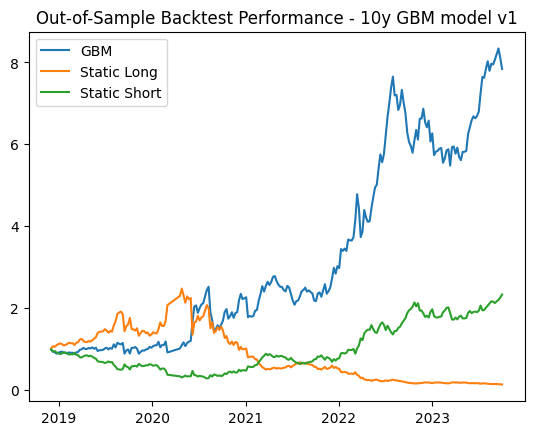

In [119]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(merged_data.index, merged_data['cumulative_ret'], label='GBM')
plt.plot(merged_data.index, merged_data['static_long_ret'], label='Static Long')
plt.plot(merged_data.index, merged_data['static_short_ret'], label='Static Short')
plt.title('Out-of-Sample Backtest Performance - 10y GBM model v1')
plt.legend()